<center><img src="./images/nup_logo_dark.jpeg" width=300 style="display: inline-block;"></center> 

## Advanced Machine Learning
### Reinforcement learning intro, practice

<br />
<br />
February 18, 2025

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1igPnv-YJprmpiw8HaJZK_QVJ-L85o4uK?usp=sharing)

## Import libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

### RiverSwim Problem


![river_swim_problem](images/river_swim_problem.jpg)

[https://arxiv.org/pdf/1306.0940.pdf](https://arxiv.org/pdf/1306.0940.pdf)

Problem based on Markov processes. There are only two actions — to try to swim against the current or not to try.

In [2]:
class RiverSwim:
    def __init__(self, 
                 isc = 4, # intermediate states count — number of states excluding first and last
                 max_steps = 16, # the maximum number of steps we take in one episode
                 lr   = 5/1000, # left reward 
                 rr   = 1.0, # right reward
                 seed = 42):
        self.rs = np.random.RandomState(seed)
        self._max_steps = max_steps
        self._interm_states = isc

        self._steps = 0
        self._current_state = 1

        self.lr = lr
        self.rr = rr
        
    @property
    def action_count(self):
        return 2
    
    @property
    def states_count(self):
        return 2 + self._interm_states
    
    def _get_probs(self, action):
        if action == 0:
            if self._current_state == 0:
                return [0.00, 1.00, 0.00]
            else:
                return [1.00, 0.00, 0.00]
            
        elif action == 1:
            if self._current_state == 0:
                return [0.00, 0.40, 0.60]
            if self._current_state == self.states_count - 1:
                return [0.40, 0.60, 0.00]
            else:
                return [0.05, 0.60, 0.35]

    def step(self, action):
        reward = 0.0
        if self._steps >= self._max_steps:
            return self._current_state, reward, True
        
        transition = self.rs.choice(range(3), p=self._get_probs(action))
        if transition == 0:
            self._current_state -= 1
        elif transition == 1:
            pass
        else:
            self._current_state += 1

        if self._current_state == 0:
            reward = self.lr
        elif self._current_state == self.states_count - 1:
            reward = self.rr
        
        self._steps += 1
        return self._current_state, reward, False

In [3]:
class QLearningAgent:
    # n states, K actions
    def __init__(self, n, K, lr=0.2, gamma=0.95, epsilon=0.3, seed=42):
        self.rs = np.random.RandomState(seed)
        self._gamma = gamma
        self._epsilon = epsilon
        self._q_matrix = np.zeros((n, K))
        self._lr = lr

    def get_action(self, state):
        if self.rs.random() < self._epsilon:
            return self.rs.randint(0, self._q_matrix.shape[1])
        else:
            return np.argmax(self._q_matrix[state])
    
    def get_q_matrix(self):
        return self._q_matrix
        
    def start_episode(self):
        pass

    def update(self, state, action, reward, next_state):
        self._q_matrix[state, action] = (1 - self._lr) * self._q_matrix[state, action] + self._lr*(reward + self._gamma*np.max(self._q_matrix[next_state]))
        return

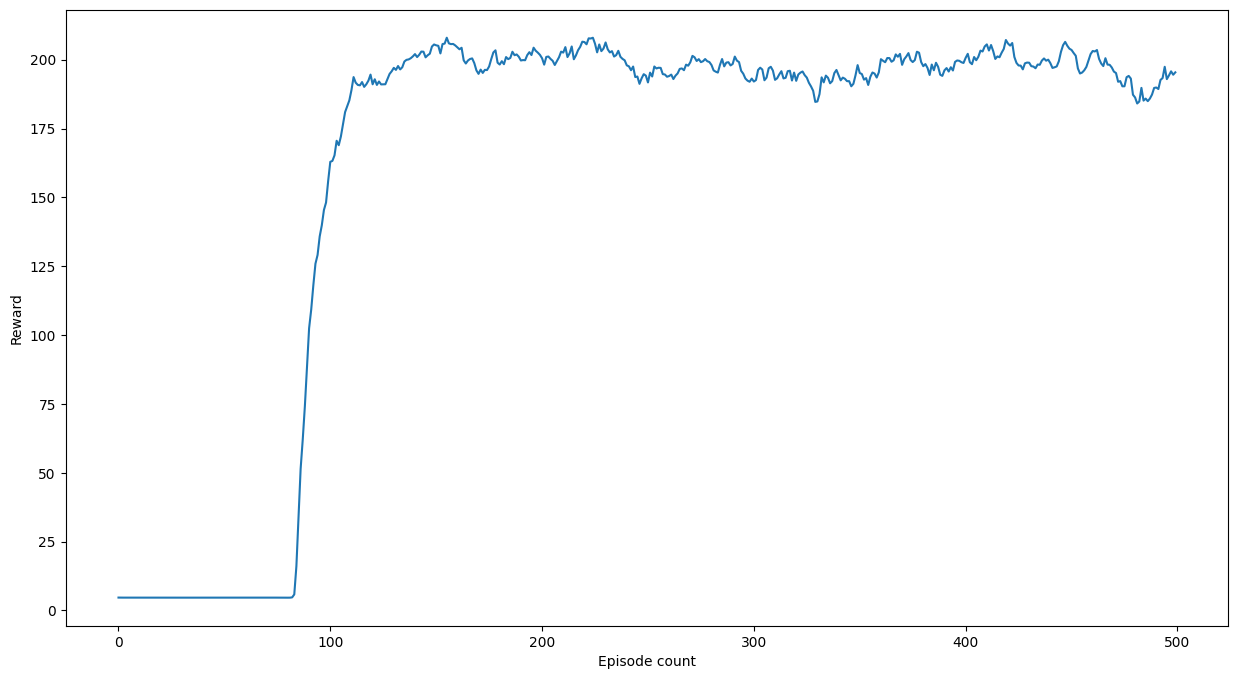

In [4]:
n = 3
ms = 1024
episodes = 500
actions = 2

agent = QLearningAgent(2+n, actions)

episode_rewards = []
for ep in range(episodes):
    river_swim = RiverSwim(n, ms)

    state, ep_reward, is_done = river_swim._current_state, 0.0, False
    agent.start_episode()
    while not is_done:
        action = agent.get_action(state)
        next_state, reward, is_done = river_swim.step(action)
        agent.update(state, action, reward, next_state)
        
        state = next_state
        ep_reward += reward
        
    episode_rewards.append(ep_reward)


plt.figure(figsize=(15, 8))

plt.plot(pd.DataFrame(np.array(episode_rewards)).ewm(alpha=.1).mean())
plt.xlabel("Episode count")
plt.ylabel("Reward")
plt.show()

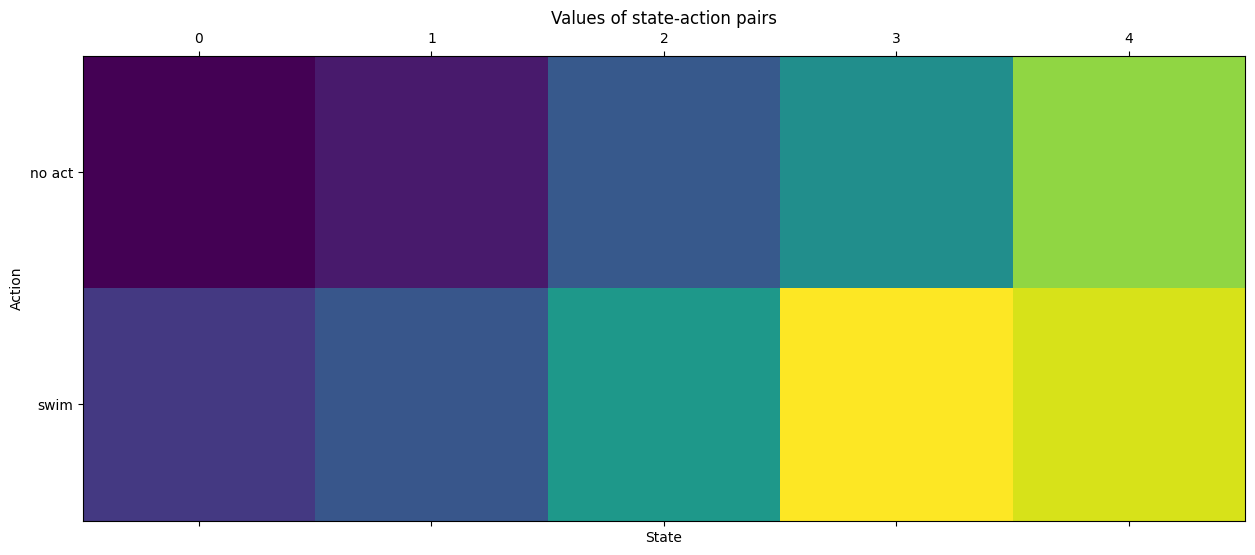

In [5]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)
ax.matshow(agent.get_q_matrix().T)
ax.set_yticks([0, 1])
ax.set_yticklabels(['no act', 'swim'])
plt.xlabel("State")
plt.ylabel("Action")
plt.title("Values of state-action pairs")
plt.show()

## A Minimal Deep Q-Network

We'll consider how to code a minimal Deep Q-Network to solve the CartPole environment.

### Step 1. Import libraries and setup the environment

In [6]:
!pip install gymnasium

  Obtaining dependency information for gymnasium from https://files.pythonhosted.org/packages/de/85/f5039ce2df5f0789ff1240f08a59f3e8c92e4c5f99543b7aad7388532f7c/gymnasium-1.0.0-py3-none-any.whl.metadata
  Obtaining dependency information for cloudpickle>=1.2.0 from https://files.pythonhosted.org/packages/7e/e8/64c37fadfc2816a7701fa8a6ed8d87327c7d54eacfbfb6edab14a2f2be75/cloudpickle-3.1.1-py3-none-any.whl.metadata
  Obtaining dependency information for farama-notifications>=0.0.1 from https://files.pythonhosted.org/packages/05/2c/ffc08c54c05cdce6fbed2aeebc46348dbe180c6d2c541c7af7ba0aa5f5f8/Farama_Notifications-0.0.4-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 5.7 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import gymnasium as gym
import numpy as np

from collections import deque
import time
import random

In [2]:
RANDOM_SEED = 5

env = gym.make('CartPole-v1', render_mode='rgb_array')
np.random.seed(RANDOM_SEED)

print("Action Space: {}".format(env.action_space))
print("State space: {}".format(env.observation_space))

Action Space: Discrete(2)
State space: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)


In [3]:
help(env.env)

Help on OrderEnforcing in module gymnasium.wrappers.common object:

class OrderEnforcing(gymnasium.core.Wrapper, gymnasium.utils.record_constructor.RecordConstructorArgs)
 |  OrderEnforcing(env: 'gym.Env[ObsType, ActType]', disable_render_order_enforcing: 'bool' = False)
 |
 |  Will produce an error if ``step`` or ``render`` is called before ``reset``.
 |
 |  No vector version of the wrapper exists.
 |
 |  Example:
 |      >>> import gymnasium as gym
 |      >>> from gymnasium.wrappers import OrderEnforcing
 |      >>> env = gym.make("CartPole-v1", render_mode="human")
 |      >>> env = OrderEnforcing(env)
 |      >>> env.step(0)
 |      Traceback (most recent call last):
 |          ...
 |      gymnasium.error.ResetNeeded: Cannot call env.step() before calling env.reset()
 |      >>> env.render()
 |      Traceback (most recent call last):
 |          ...
 |      gymnasium.error.ResetNeeded: Cannot call `env.render()` before calling `env.reset()`, if this is an intended action, set `di

### Step 2. Define the network architecture

In [4]:
# An episode a full game
train_episodes = 150

class DQNAgent(nn.Module):
    """ The agent maps X-states to Y-actions
    e.g. if the neural network output is [.1, .7, .05, 0.05, .05, .05]
    than the highest value 0.7 is the Q-Value.
    The index of the highest action (0.7) is action #1.
    """
    def __init__(self, state_shape, action_shape):
        super(DQNAgent, self).__init__()
        self.fc1 = nn.Linear(state_shape, 24)
        self.fc2 = nn.Linear(24, 12)
        self.fc3 = nn.Linear(12, action_shape)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # No activation as in your keras model
        return x

# Define a function to get Q-values
def get_qs(model, state):
    state = torch.tensor(state, dtype=torch.float32)  # Convert to PyTorch tensor
    state = state.unsqueeze(0)  # Reshape
    return model(state).detach().numpy()[0]  # Compute Q-values and convert to numpy array


def train_nn(model, X, Y, batch_size=64, shuffle=True):
    # Use GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Set the model in training mode
    model.train()

    # Define an optimizer and a loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.SmoothL1Loss()  # Huber Loss

    # Convert the data to PyTorch tensors
    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    Y_tensor = torch.tensor(Y, dtype=torch.float32).to(device)

    # Create a data loader
    dataset = torch.utils.data.TensorDataset(X_tensor, Y_tensor)
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

    epoch = 0
    for batch_x, batch_y in data_loader:
        optimizer.zero_grad()
        output = model(batch_x)
        loss = loss_fn(output, batch_y)
        loss.backward()
        optimizer.step()

    # Print loss for this epoch
    print(f"Epoch {epoch + 1}, Loss: {loss.item()}")

    return model

### Step 3. Define the train function using Experience Replay

In [5]:
def get_array(obs):
    return obs[0] if type(obs) is tuple else obs


def train(env, replay_memory, model, target_model, done):
    learning_rate = 0.7
    discount_factor = 0.618

    MIN_REPLAY_SIZE = 1000
    if len(replay_memory) < MIN_REPLAY_SIZE:
        return

    batch_size = 64 * 2
    # replay_memory is list of [observation, action, reward, new_observation, done])
    mini_batch = random.sample(replay_memory, batch_size)

    current_states = np.array([get_array(transition[0]) for transition in mini_batch], dtype='float32')
    current_qs_list = model(torch.tensor(current_states))
    new_current_states = np.array([get_array(transition[3]) for transition in mini_batch], dtype='float32')
    future_qs_list = target_model(torch.tensor(new_current_states))

    X = []
    Y = []
    for index, (observation, action, reward, new_observation, done) in enumerate(mini_batch):
        if not done:
            max_future_q = reward + discount_factor * np.max(future_qs_list[index].detach().numpy())
        else:
            max_future_q = reward

        current_qs = current_qs_list[index].detach().numpy()
        current_qs[action] = (1 - learning_rate) * current_qs[action] + learning_rate * max_future_q

        X.append(get_array(observation))
        Y.append(current_qs)
    model = train_nn(model, np.array(X, dtype='float32'), np.array(Y, dtype='float32'),
                     batch_size=batch_size, shuffle=True)


### Step 4. Run the Deep Q-Network Algorithm

In [6]:
def main():
    epsilon = 1 # Epsilon-greedy algorithm in initialized at 1 meaning every step is random at the start
    max_epsilon = 1 # You can't explore more than 100% of the time
    min_epsilon = 0.01 # At a minimum, we'll always explore 1% of the time
    decay = 0.01

    # 1. Initialize the Target and Main models
    # Main Model (updated every 4 steps)
    model = DQNAgent(env.observation_space.shape[0], env.action_space.n)
    # Target Model (updated every 100 steps)
    target_model = DQNAgent(env.observation_space.shape[0], env.action_space.n)
    target_model.load_state_dict(model.state_dict())

    replay_memory = deque(maxlen=50_000)

    target_update_counter = 0

    # X = states, y = actions
    X = []
    y = []

    steps_to_update_target_model = 0

    for episode in range(train_episodes):
        total_training_rewards = 0
        observation = env.reset()
        done = False
        while not done:
            steps_to_update_target_model += 1
            #if True:
            #    env.render()

            random_number = np.random.rand()
            # 2. Explore using the Epsilon Greedy Exploration Strategy
            if random_number <= epsilon:
                # Explore
                action = env.action_space.sample()
            else:
                # Exploit best known action
                # model dims are (batch, env.observation_space.n)
                encoded = get_array(observation)
                encoded_reshaped = torch.from_numpy(encoded.reshape([1, encoded.shape[0]]))
                predicted = model(encoded_reshaped).detach().numpy().flatten()
                action = np.argmax(predicted)
            new_observation, reward, done, info, _ = env.step(action)
            replay_memory.append([observation, action, reward, new_observation, done])

            # 3. Update the Main Network using the Bellman Equation
            if steps_to_update_target_model % 4 == 0 or done:
                train(env, replay_memory, model, target_model, done)

            observation = new_observation
            total_training_rewards += reward

            if done:
                print('Total training rewards: {} after n steps = {} with final reward = {}'.format(total_training_rewards, episode, reward))
                total_training_rewards += 1

                if steps_to_update_target_model >= 100:
                    print('Copying main network weights to the target network weights')
                    target_model.load_state_dict(model.state_dict())
                    steps_to_update_target_model = 0
                break

        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay * episode)
    env.close()
    return model


In [7]:
policy = main()

Total training rewards: 17.0 after n steps = 0 with final reward = 1.0
Total training rewards: 13.0 after n steps = 1 with final reward = 1.0
Total training rewards: 12.0 after n steps = 2 with final reward = 1.0
Total training rewards: 28.0 after n steps = 3 with final reward = 1.0
Total training rewards: 16.0 after n steps = 4 with final reward = 1.0
Total training rewards: 14.0 after n steps = 5 with final reward = 1.0
Copying main network weights to the target network weights
Total training rewards: 12.0 after n steps = 6 with final reward = 1.0
Total training rewards: 27.0 after n steps = 7 with final reward = 1.0
Total training rewards: 14.0 after n steps = 8 with final reward = 1.0
Total training rewards: 21.0 after n steps = 9 with final reward = 1.0
Total training rewards: 21.0 after n steps = 10 with final reward = 1.0
Total training rewards: 20.0 after n steps = 11 with final reward = 1.0
Copying main network weights to the target network weights
Total training rewards: 10.0

In [8]:
from IPython import display as ipythondisplay

In [9]:
!pip install 'gymnasium[classic_control]'


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


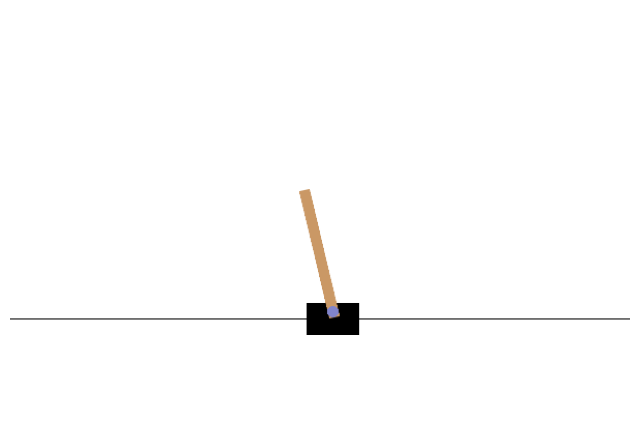

In [14]:
import gymnasium as gym
import matplotlib.pyplot as plt

from time import sleep
from IPython import display as ipythondisplay

# Create environment with rgb_array render mode
env = gym.make('CartPole-v1', render_mode="rgb_array")

# Create a figure for displaying the environment
plt.figure(figsize=(8, 6))

# Simple policy that always moves right
policy_dummy = lambda *obs: 1

for episode in range(2):
    obs, info = env.reset()
    for step in range(80):
        # Get action from policy
        action = policy_dummy(obs)

        # Take action in environment
        obs, reward, done, truncated, info = env.step(action)
        sleep(0.05)
        

        # Render and display
        screen = env.render()
        plt.clf()  # Clear the current figure
        plt.imshow(screen)
        plt.axis('off')  # Hide axes for cleaner display
        ipythondisplay.clear_output(wait=True)
        ipythondisplay.display(plt.gcf())

        if done or truncated:
            break

ipythondisplay.clear_output(wait=True)
env.close()
plt.close()

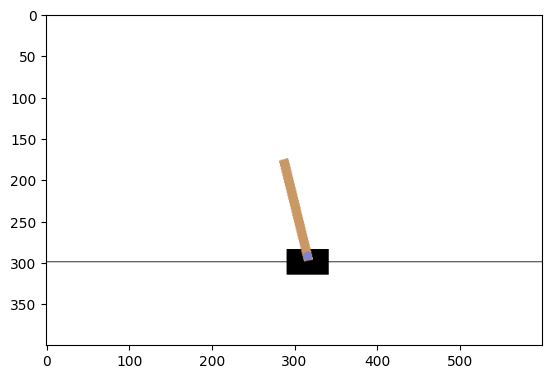

In [15]:
prev_screen = env.render()
plt.imshow(prev_screen)

policy_dummy = lambda *obs: 1

for _ in range(2):
    obs = env.reset()
    for _ in range(80):
        actions = policy_dummy(*obs)
        obs, reward, done, truncated, info = env.step(actions)
        sleep(0.05)
        
        screen = env.render()

        plt.imshow(screen)
        ipythondisplay.clear_output(wait=True)
        ipythondisplay.display(plt.gcf())

        if done:
            break

ipythondisplay.clear_output(wait=True)
env.close()

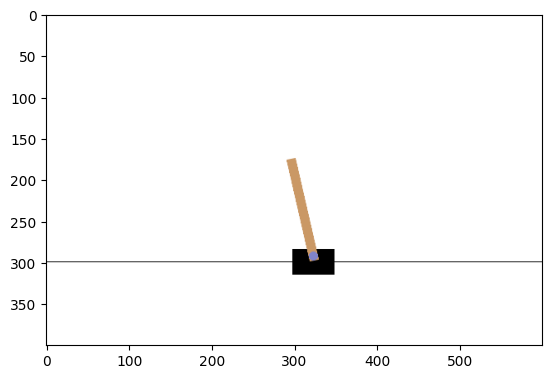

In [18]:
prev_screen = env.render()
plt.imshow(prev_screen)


for _ in range(1):
    obs = env.reset()
    for _ in range(80):
        encoded = get_array(obs)
        encoded_reshaped = torch.from_numpy(encoded.reshape([1, encoded.shape[0]]))
        predicted = policy(encoded_reshaped).detach().numpy().flatten()
        action = np.argmax(predicted)
        obs, reward, done, truncated, info = env.step(action)
        sleep(0.05)

        screen = env.render()

        plt.imshow(screen)
        ipythondisplay.clear_output(wait=True)
        ipythondisplay.display(plt.gcf())

        if done:
            break

ipythondisplay.clear_output(wait=True)
env.close()

In [22]:
from torchsummary import summary

summary(policy, (4,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 24]             120
            Linear-2                   [-1, 12]             300
            Linear-3                    [-1, 2]              26
Total params: 446
Trainable params: 446
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------
